In [1]:
import pandas as pd
import numpy as np
import os
import glob
import  PIL
from PIL import Image
import cv2
import time
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
%matplotlib inline

# custom function
from data_cleaning import *

Using TensorFlow backend.


In [2]:
# get_img_stats is a function loaded in from data_cleaning.py
# it loops through each directory and gets the dimensions of each image and prints the minimum
test_algae = "split/test/algae/*"
test_not_algae = "split/test/not_algae/*"
get_img_stats(test_algae)
get_img_stats(test_not_algae)

train_algae = "split/train/algae/*"
train_not_algae = "split/train/not_algae/*"
get_img_stats(train_algae)
get_img_stats(train_not_algae)

val_algae = "split/validation/algae/*"
val_not_algae = "split/validation/not_algae/*"
get_img_stats(val_algae)
get_img_stats(val_not_algae)

images appended!
(140, 100)
images appended!
(160, 237)
images appended!
(140, 100)
images appended!
(153, 110)
images appended!
(140, 100)
images appended!
(200, 160)


In [21]:
# build a baseline data generator
train_dir = 'split/train/'
validation_dir = 'split/validation/'
test_dir = 'split/test/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(140, 140),
                                                    batch_size=32)

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(140, 140),
                                                        batch_size=32)
                                                        #class_mode='binary')

Found 867 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


In [22]:
# instantiate the model 
model = models.Sequential()

# you need alternating convolutional and pooling layers
# first kernel_size is 7x7 because my image size is > 128x128
# source: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

model.add(layers.Conv2D(32, (7, 7), activation='relu',
                        input_shape=(140, 140, 3))) # in the first layer add an input shape
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

# add in metrics for evaluations
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [23]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 117s 1s/step - loss: 0.6002 - acc: 0.6735 - val_loss: 0.4432 - val_acc: 0.8196
Epoch 2/30
100/100 [==============================] - 114s 1s/step - loss: 0.4803 - acc: 0.7665 - val_loss: 0.6981 - val_acc: 0.8574
Epoch 3/30
100/100 [==============================] - 103s 1s/step - loss: 0.4227 - acc: 0.8121 - val_loss: 0.2752 - val_acc: 0.8711
Epoch 4/30
100/100 [==============================] - 103s 1s/step - loss: 0.4074 - acc: 0.8312 - val_loss: 0.4759 - val_acc: 0.8797
Epoch 5/30
100/100 [==============================] - 97s 967ms/step - loss: 0.3559 - acc: 0.8411 - val_loss: 0.5366 - val_acc: 0.8883
Epoch 6/30
100/100 [==============================] - 97s 971ms/step - loss: 0.3723 - acc: 0.8434 - val_loss: 0.0633 - val_acc: 0.8883
Epoch 7/30
100/100 [==============================] - 98s 980ms/step - loss: 0.3391 - acc: 0.8583 - val_loss: 0.4828 - val_acc: 0.8935
Epoch 8/30
100/100 [==============================] - 98s 976ms

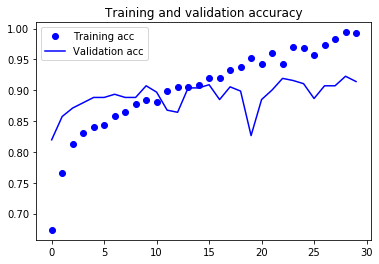

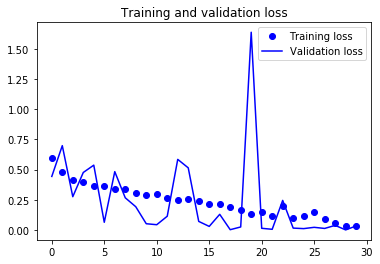

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
model.save('hab_test_model.h5')

In [26]:
#augment the images
train_datagen = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=90, 
                                     brightness_range=[0.2,1.5], 
                                     horizontal_flip=True) 
                                                          

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(140, 140),
        batch_size=32)

validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        target_size=(140, 140), 
                                                        batch_size=32)

Found 867 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


In [29]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/30
  8/100 [=>............................] - ETA: 1:53 - loss: 0.1446 - acc: 0.9339

KeyboardInterrupt: 

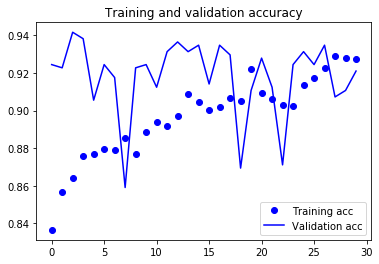

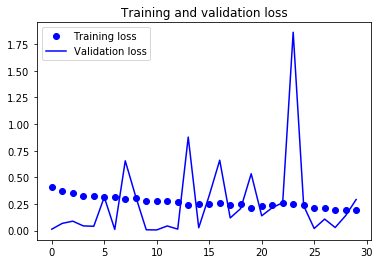

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [31]:
# final evaluation
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(140, 140), 
                                                  batch_size=20)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 288 images belonging to 2 classes.
test acc: 0.8672199249267578
